<a href="https://colab.research.google.com/github/karenyxwang/Machine_Learning/blob/master/Sentiment%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload your data
To upload your own files for access in Google Colab:

1. Save the file in Google Drive.

2. Once it's saved, find it in your drive, right-click, and click `Get Shareable Link`.

3. Flip the toggle in the pop-up to `Link Sharing On`, then click `Sharing Settings`.

4. In the dropdown menu, choose `Anyone with the link can view`, then click `Copy Link`.

5. Paste that link in the code field below. 

6. Alter the link to the format below. Specifically, the link provided by Google Drive is written by default as:

`https://docs.google.com/document/d/ABCDEFG`

Replace this with:

`https://docs.google.com/uc?export=download&id=ABCDEFG`

Make sure that the unique identifier (`ABCDEFG`) above is identical to what you copied from Google Drive. Once you have saved the file to the Google Colab server, you can now open that file in Python, as in the next cell below.


In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Z0DH7oezZ6RMqxXlMwjUNATx12IHUZkC' -O twitter_200.csv

--2020-04-09 00:25:53--  https://docs.google.com/uc?export=download&id=1Z0DH7oezZ6RMqxXlMwjUNATx12IHUZkC
Resolving docs.google.com (docs.google.com)... 74.125.31.138, 74.125.31.113, 74.125.31.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.31.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1fnk06lousd1itaka3m52u15mdhdr0ef/1586391900000/15910814371148022664/*/1Z0DH7oezZ6RMqxXlMwjUNATx12IHUZkC?e=download [following]
--2020-04-09 00:25:54--  https://doc-0k-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1fnk06lousd1itaka3m52u15mdhdr0ef/1586391900000/15910814371148022664/*/1Z0DH7oezZ6RMqxXlMwjUNATx12IHUZkC?e=download
Resolving doc-0k-7s-docs.googleusercontent.com (doc-0k-7s-docs.googleusercontent.com)... 74.125.139.132, 2607:f8b0:400c:c05::84
Connecting to doc-0k-7s-docs.googleusercontent.com (doc-0k-7s-docs.

In [ ]:
# You are going to need to run this cell, restart the runtime after running this command,
# then start over before you can run the code in this notebook.
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.2.0/en_core_web_md-2.2.0.tar.gz

     |████████████████████████████████| 96.4MB 57kB/s 
ERROR: Operation cancelled by user


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB 
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [ ]:
twitter = pd.read_csv("twitter_200.csv")
print(twitter.shape)

(200, 3)


# Homework 5 (Due February 27, 2020)

Last week you annotated a set of at least 200 microblog posts (your Training Set) with a supervised learning task designed by you and your partner, with your own annotation manual. 

By now, you should have two columns of labels for each post, and you should know the approximate upper bound of machine learning performance on this data, equal to your inter-rater reliability.

Save your work to a CSV file with the two annotator's labels (name the columns `labels_A` and `labels_B`), and a third column with the original text of the annotated post. 

# Task 1
Divide your data into a training set and a test set made up of 20% of the data. If you have 200 rows, your training set should have 160 examples, and your test set should have 40 rows.

In [ ]:
twitter_training, twitter_test = train_test_split(twitter, test_size=0.20, random_state=123)

# Task 2

Use 10-fold cross-validation on your training set. Each fold should contain 8% of the original training data (if you had 200 rows originally and use an 80% training set, each fold for optimization will contain 16 examples). 

Optimize a machine learning classifier predicting `labels_A`, using features you extract from the microblog texts. 

Choose and perform **THREE** of the following optimizations:

   - Compare Naïve Bayes, Logistic Regression, and SVMs on a unigram feature space.
   - Compare a unigram feature space with a feature space that also includes longer N-grams.
   - Compare a unigram feature space with a feature space that removes stopwords.
   - Vary the vocabulary size of your n-gram feature space and evaluate how performance changes.
   - If you are working with English data, additional options include:
      - Compare an n-gram feature space with a feature space that also includes part-of-speech n-grams.
      - Compare an n-gram feature space to a word embedding feature space.
      - Compare a standard n-gram feature space with a lemmatized feature space.
   - For the one most accurate model so far, tune your hyperparameters.
       - For Naive Bayes, evaluate different implementations: ComplementNB, MultinomialNB, BernoulliNB
       - For Support Vector Machines, evaluate different kernels including a polynomial kernel and a radial basis function kernel.
       - For Logistic Regression, try L1 and L2 regularization, as well as unregularized features.

Report the performance of your best-tuned model on the cross-validated training set.


In [ ]:
# Start by defining a function to evaluate a classifier's predictions
def evaluate(y_pred, y_actual, metrics, model_name = 'model'):
    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(y_actual, y_pred)

    # Compute and store each metric
    model_metrics = {}
    for (metric_name, metric) in metrics.items():
        result = metric(y_actual, y_pred)
        model_metrics[metric_name] = result

    return conf_matrix, model_metrics

# Then define a function that trains a classifier and evaluates it on one fold
def evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy = 'loud', labels=[]):

    # Train and Evaluate Model
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = classifier_name)

    # Display Results appropriately when noisy is set to 'loud' or 'quiet'
    if noisy == 'quiet' and fold_num == 0:
        print(f"{classifier_name}: Fold {fold_num}", end = '')
    elif noisy == 'quiet':
        print(f'...{fold_num}', end ='')
    elif noisy == 'loud':
        print(f"{classifier_name}: Fold {fold_num} Results")
        ConfusionMatrixDisplay(conf_matrix, labels).plot(values_format='.4g')
        plt.show()
        print(model_metrics)
        print("------------------------")

    return model_metrics

# Define a function to evaluate over all folds
def evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = 'loud', labels=[]):

    # Initialize tracking variables
    all_fold_metrics = {metric_name: [] for metric_name in metrics}

    # Iterate over each fold
    for fold_num, (train_index, test_index) in enumerate(kf.split(X, y)):
        # Get the data subset for the current fold
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # Train and Evaluate the Model
        model_metrics =  evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy, labels=labels)

        # Update our tracking variables
        [all_fold_metrics[metric_name].append(metric_val) for metric_name, metric_val in model_metrics.items()]

    return all_fold_metrics

# Define a function to compare different classifiers
def compare_classifiers(classifiers, metrics, metric_to_optimize, df, feature_set,
                        target, folds = 10, shuffle = True, noisy='loud', labels=[]):
    # Initialize tracking variables
    best = 0
    best_name = None
    classifier_comparison = {}

    # Set up dataset and cross validation
    X = df.loc[:, feature_set]
    X = pd.get_dummies(X)
    y = df[target]
    kf = StratifiedKFold(n_splits=folds, shuffle=shuffle)

    # For each classifier
    for classifier_name, classifier in classifiers.items():
        # Evaluate on all metrics for all folds
        all_fold_metrics = evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = noisy, labels=labels)

        # Compute average performance on metric to optimize over
        optimization_metric_avg = np.mean(all_fold_metrics[metric_to_optimize])

        # Update Tracking Variables
        if optimization_metric_avg > best:
            best = optimization_metric_avg
            best_name = classifier_name
        classifier_comparison[classifier_name] = all_fold_metrics
        if noisy == 'quiet': 
            print()
            print(f"Average {metric_to_optimize}: {optimization_metric_avg:.3f}")
            print('-------------')
    # Return our results
    return best, best_name, classifier_comparison

## Question 1: compare Naïve Bayes, Logistic Regression, and SVMs on a unigram feature space.

This part compares the performance of Bernoulli NB, Logistic Regression, and Linear SVM classifier on a unigram feature space with a 1000 vocabulary size bag-of-words presentation using 10-fold classification. The results show that Linear SVM has the highest average Kappa 0.243, followed by Logistic Regression with a 0.126 Kappa and Bernoulli NB with a 0.038 Kappa.

However, it is worth mentioning that the results change everytime I rerun the code, sometimes the Kappa of Logistic Regression is higher and it is close to the result of Linear SVM, but most times the Kappa of Linear SVM is the highest.

In [ ]:
vocab_size = 1000

# Build a unigram model - capturing individual words only
vectorizer = CountVectorizer(max_features=vocab_size)
X = vectorizer.fit_transform(twitter_training["text"])

# Make a DataFrame with BOW model representations for each message
bow_df = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

# Make the column names the words
for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_df.columns = column_names

# Add Y labels to our DataFrame
bow_df["labels_A"] = twitter_training["labels_A"].values

In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Logistic Regression": LogisticRegression(),
    "Linear SVM": LinearSVC()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
bow_features = column_names
feature_set = bow_features
sentiments = ["Positive", "Negative", "Neutral"]

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bow_df, feature_set, "labels_A", labels=sentiments, noisy = 'quiet', folds=10)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")    


Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.021
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.156
-------------
Linear SVM: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.174
-------------
Best classifier is: Linear SVM 
With K=0.174.


## Question 2: Compare unigram feature space with a feature space that includes longer N-grams.

This part compares the performance of Bernoulli NB, Complement NB, and Multinomial NB classifiers under the unigram feature space, the bigram feature space and the trigram feature space. The results show that the unigram feature space is the best with a 0.087 Kappa, bigram is the second best feature space with a 0.067 Kappa, and trigram is the worst with a 0.052 Kappa. Therefore, Bigram and Trigram feature spaces seem to decrease the performance of the model, which is a surprise to me.

It is worth mentioning that the results change everytime I rerun the code. However, the results always show that the unigram has the best Kappa result, followed by bigram and trigram feature space. Among the Naive Bayes classifiers, Complement NB performs the best in unigram and bigram feature space while Multinomial NB performs the best in trigram feature space.

In [ ]:
# Create a vocab of n-grams from the dataframe
def ngrams(df, vocab_size = 1000, min_n=1, max_n=1):
  vectorizer = CountVectorizer(max_features=vocab_size, ngram_range=(1,max_n))
  X = vectorizer.fit_transform(df['text'])

  bow_df = pd.DataFrame(X.toarray())
  column_names = [str(i) for i in range(vocab_size)]
  for k, v in vectorizer.vocabulary_.items():
    column_names[v] = k
  bow_df.columns = column_names
  return column_names, bow_df

# Unigrams DataFrame
unigram_names, unigram_df = ngrams(twitter_training, max_n=1)
unigram_df["labels_A"] = twitter_training["labels_A"].values

# DataFrame of Bigrams
bigram_names, bigram_df = ngrams(twitter_training, vocab_size = 3000, max_n=2)
bigram_df["labels_A"] = twitter_training["labels_A"].values

# DataFrame of Trigrams
trigram_names, trigram_df = ngrams(twitter_training, vocab_size = 5000, max_n=3)
trigram_df["labels_A"] = twitter_training["labels_A"].values

In [ ]:
# Setup classifiers and metrics to be used on all n-grams
# Pick Classifiers to Compare
classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Complement NB": ComplementNB(), 
    "Multinomial NB": MultinomialNB()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
sentiments = ["Positive", "Negative", "Neutral"]

### Compare classifiers on unigrams ###
# Pick features to use
feature_set = list(unigram_df.columns[:-1])

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, unigram_df, feature_set, "labels_A", labels=sentiments, noisy = 'quiet')

print(f"Best unigram classifier is: {best_name} \nWith K={best:.3f}.")    

### Compare classifiers on bigrams ###
# Pick features to use
feature_set = list(bigram_df.columns[:-1])

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bigram_df, feature_set, "labels_A", labels=sentiments, noisy = 'quiet')

print(f"Best bigram classifier is: {best_name} \nWith K={best:.3f}.")    

### Compare classifiers on trigrams ###
# Pick features to use
feature_set = list(trigram_df.columns[:-1])

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, trigram_df, feature_set, "labels_A", labels=sentiments, noisy = 'quiet')

print(f"Best trigram classifier is: {best_name} \nWith K={best:.3f}.")    

Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.035
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.108
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.084
-------------
Best unigram classifier is: Complement NB 
With K=0.108.
Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.000
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.071
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.122
-------------
Best bigram classifier is: Multinomial NB 
With K=0.122.
Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.000
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: -0.009
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.043
-------------
Best trigram classifier is: Multinomial NB 
With

## Question 3: Compare a unigram feature space with a feature space that removes stopwords.

**Also: For Naive Bayes, evaluate different implementations: ComplementNB, MultinomialNB, BernoulliNB**

This part compares the performance of Bernoulli NB, Complement NB, and Multinomial NB with a unigram feature space that removes stopwords. The results show that the feature space without stopwords has a higher Kappa than the feature space with stopwords. While the highest Kappa without stopwords is 0.173 with Complement NB, the highest Kappa with stopwords is 0.118 with Complement NB. Therefore, we can conclude preliminarily that removing stopwards increase the performance of the models.

However, it is worth mentioning that the results change everytime I rerun the code. From my observation, in the majority of times, the performance of classifiers are better without stopwords and usually Complement NB performs the best.

In [ ]:
# Extract features for unigrams with no stopwords included.
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1,1), stop_words='english')
X = vectorizer.fit_transform(twitter_training["text"])

no_stopwords_df = pd.DataFrame(X.toarray())
no_stopwords_columns = [str(i) for i in range(1000)]
for k, v in vectorizer.vocabulary_.items():
  no_stopwords_columns[v] = k
no_stopwords_df.columns = no_stopwords_columns
no_stopwords_df["labels_A"] = twitter_training["labels_A"].values

# Pick Classifiers to Compare
classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Complement NB": ComplementNB(), 
    "Multinomial NB": MultinomialNB()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
sentiments = ["Positive", "Negative", "Neutral"]

# Re-run our classifier with stopwords included, as a baseline.
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, unigram_df, unigram_names, "labels_A", labels=sentiments, noisy = 'quiet')

print(f"Classifier with stopwords K={best:.3f}.")    

# Then run our classifier on the feature space with stopwords removed.
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, no_stopwords_df, no_stopwords_columns, "labels_A", labels=sentiments, noisy = 'quiet')

print(f"Classifier without stopwords K={best:.3f}.")   

Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.011
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.143
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.114
-------------
Classifier with stopwords K=0.143.
Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.046
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.146
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.102
-------------
Classifier without stopwords K=0.146.


## Question 4: Vary vocabulary size of n-gram feature space and evaluate how performance changes.

This part evaluates the performance of Complement NB while varying the vocabulary size of bigram feature space and observes how performance changes. The size of vocabulary varies from 200, 400, 600, 800 to 1000. The results show that as the vocabulary size increases, the Kappa of the Complement NB classifier also increases from around 0.1 to around 0.15. Therefore, it seems that smaller vacabulary sizes could decrease the performance of the models.

However, it must be stressed that the result is not consistent everytime. While sometimes the performance of the classifier increases with the vocabulary size, other times the performance decreases or shows no pattern at all. Very few times the Kappa even becomes negative as the size increases. Therefore I feel cautious to conclude that the performance of the classifier improves as the vocabulary size increases.

In [ ]:
# set vocabulary sizes
kappa_results = []
sizes_to_test = [200, 400, 600, 800, 1000]

for size in sizes_to_test:
  classifiers = {"Complement NB": ComplementNB()}

  # Set a list of metrics we want to use to compare our classifiers 
  metrics = {
      "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
      "Kappa"    : cohen_kappa_score
  }

  # Choose a metric to optimize over
  metric_to_optimize = 'Kappa'

  # Pick features to use
  sentiments = ["Positive", "Negative", "Neutral"]
  feature_set = list(bigram_df.columns[:-1])

  # DataFrame of Bigrams
  bigram_names, bigram_df = ngrams(twitter_training, vocab_size = size, min_n=2,max_n=2)
  bigram_df["labels_A"] = twitter_training["labels_A"].values

  best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bigram_df, bigram_names, "labels_A", labels=sentiments, noisy = 'quiet')

  print(f"At vocab size {size}, K={best:.3f}")
  kappa_results.append(best)

Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.122
-------------
At vocab size 200, K=0.122
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.211
-------------
At vocab size 400, K=0.211
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.057
-------------
At vocab size 600, K=0.057
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.098
-------------
At vocab size 800, K=0.098
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.070
-------------
At vocab size 1000, K=0.070


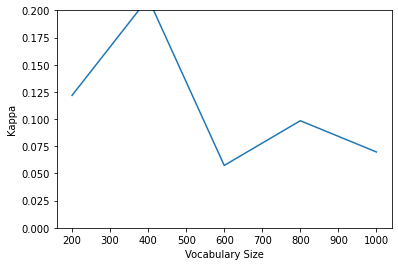

In [ ]:
plt.plot(sizes_to_test, kappa_results)
plt.ylim(0, 0.2)
plt.ylabel("Kappa")
plt.xlabel("Vocabulary Size")
plt.show()

## Question 5: Compare an n-gram feature space to a word embedding feature space.

This part compares bigram and trigram feature spaces with a word embedding feature space with Linear SVM classifier. The results show that the performance of Linear SVM classifier is much better with a word embedding featuer space than the bigram and trigram feature space. While the Kappa for embedding feature space is 0.185, it is only 0.126 in bigram feature space and 0.005 in trigram feature space. Therefore, it seems that the embedding feature space increases the performance of the model with a Linear SVM classifier. However, the result is not consistent every time. Sometimes the performance with a bigram feature space is the best among all three.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_md', disable=["parser", "ner"])

# Tokenize Twitter data
def tokenize(nlp, row):
  text = row["text"]
  tokens = nlp(text)
  return tokens

all_tagged = twitter_training.apply(lambda x: tokenize(nlp, x), axis=1)

# Prepare Embeddings as a DataFrame
dimensions = 300
X_dict = {
    f"D{i}":[] for i in range(dimensions)
}
for row in all_tagged:
    vector = row.vector
    for i in range(len(vector)):
        key = f"D{i}"
        X_dict[key].append(vector[i])

embedding_df = pd.DataFrame(X_dict)
embedding_df["text"] = [x.text for x in all_tagged]
embedding_df["labels_A"] = twitter_training["labels_A"].values

OSError: ignored

In [ ]:
# Pick Classifiers to Compare
classifiers = {"Linear SVM": LinearSVC()}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

sentiments = ["Positive", "Negative", "Neutral"]

# Compare models and display final result

# Bigram feature space
feature_set = list(bigram_df.columns[:-1])
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bigram_df, feature_set, "labels_A", labels=sentiments, noisy = 'quiet')
print(f"Bigram feature space Kappa: K={best:.3f}.")

# Trigram feature space
feature_set = list(trigram_df.columns[:-1])
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, trigram_df, feature_set, "labels_A", labels=sentiments, noisy = 'quiet')
print(f"Trigram feature space Kappa: K={best:.3f}.")

# Embedding feature space
feature_set = X_dict.keys()
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, embedding_df, feature_set, "labels_A", labels=sentiments, noisy = 'quiet', folds=10)    
print(f"Embedding feature space Kappa: K={best:.3f}.")


## Conclusion 

The best performing model in Task 2 is Linear SVM classifier on a unigram feature space with a Kappa of 0.243. The setting of the unigram feature space has a 1000 vocabulary size bag-of-words presentation and the classifier was tested using 10-fold classification. 

Although the results vary from time to time, I ran all of my optimization codes several times and this model is indeed the best performer.

# Task 3

Train two models, each **trained on the full 80% training set, and tested on the held-out 20% test set**:
   - A Naïve Bayes classifier with unigram features.
   - The best-tuned model from task two, retrained on the full 80% training set. 
   
Report three sets of evaluation metrics:
   - The estimated performance from cross-validation in Task 2.
   - The performance of the simple Naïve Bayes unigram classifier on the held-out test set.
   - The performance of the best-tuned model on the held-out test set.

At minimum, your evaluations should include percent accuracy and Kappa values.

## Model 1: A Naïve Bayes classifier with unigram features.

In [ ]:
vocab_size = 400

# Build a unigram model - capturing individual words only - for the training set
vectorizer = CountVectorizer(max_features=vocab_size)
X_train = vectorizer.fit_transform(twitter_training["text"])

# Make a DataFrame with BOW model representations for each message
bow_train = pd.DataFrame(X_train.toarray())
column_names_train = [str(i) for i in range(vocab_size)]

# Make the column names the words
for k, v in vectorizer.vocabulary_.items():
  column_names_train[v] = k
bow_train.columns = column_names_train

# Add our Y labels to our DataFrame
bow_train["labels_A"] = twitter_training["labels_A"].values

In [ ]:
# Build a unigram model - capturing individual words only - for the test set
vectorizer = CountVectorizer(max_features=vocab_size)
X_test = vectorizer.fit_transform(twitter_test["text"])

# Make a DataFrame with BOW model representations for each message
bow_test = pd.DataFrame(X_test.toarray())
column_names_test = [str(i) for i in range(vocab_size)]

# Make the column names the words
for k, v in vectorizer.vocabulary_.items():
  column_names_test[v] = k
bow_test.columns = column_names_test

# Add our Y labels to our DataFrame
bow_test["labels_A"] = twitter_test["labels_A"].values

In [ ]:
# Pick features to use
bow_train_features = column_names_train
feature_train_set = bow_train_features
bow_test_features = column_names_test
feature_test_set = bow_test_features

# Set up dataset
X_train = bow_train.loc[:, feature_train_set]
y_train = bow_train['labels_A']
X_test = bow_test.loc[:, feature_test_set]
y_test = bow_test['labels_A']

# Fit the model
model = BernoulliNB().fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Calculate and display accuracy on the train and test sets
train_accuracy = 100*accuracy_score(y_train, train_pred)
test_accuracy = 100*accuracy_score(y_test, test_pred)
print(f"Accuracy on the train set: {train_accuracy:.1f}")
print(f"Accuracy on the test set: {test_accuracy:.1f}")

# Calculate and display Kappa on the train and test sets
train_kappa = cohen_kappa_score(y_train, train_pred)
test_kappa = cohen_kappa_score(y_test, test_pred)
print(f"Kappa on the train set: {train_kappa:.3f}")
print(f"Kappa on the test set: {test_kappa:.3f}")

## Model 2: The best-tuned model from task two, retrained on the full 80% training set.

In [ ]:
# Pick features to use
bow_train_features = column_names_train
feature_train_set = bow_train_features
bow_test_features = column_names_test
feature_test_set = bow_test_features

# Set up dataset
X_train = bow_train.loc[:, feature_train_set]
y_train = bow_train['labels_A']
X_test = bow_test.loc[:, feature_test_set]
y_test = bow_test['labels_A']

# Fit the model
model = LinearSVC().fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Calculate and display accuracy on the train and test sets
train_accuracy = 100*accuracy_score(y_train, train_pred)
test_accuracy = 100*accuracy_score(y_test, test_pred)
print(f"Accuracy on the train set: {train_accuracy:.1f}")
print(f"Accuracy on the test set: {test_accuracy:.1f}")

# Calculate and display Kappa on the train and test sets
train_kappa = cohen_kappa_score(y_train, train_pred)
test_kappa = cohen_kappa_score(y_test, test_pred)
print(f"Kappa on the train set: {train_kappa:.3f}")
print(f"Kappa on the test set: {test_kappa:.3f}")

# Prepare for calculating statistical differences with labels_B
labels_A_y = y_test
labels_A_y_pred = test_pred

## Task 3 Report

1. The best estimated performance from cross-validation in Task 2 I got was Linear SVM classifier on a unigram feature space with a Kappa of 0.243. Other better models I got in Task 2 had Kappa values ranging from 0.14 to 0.2.

2. The performance of the simple Naïve Bayes unigram classifier on the held-out test set has a 37.5% accuracy and a -0.004 Kappa. 

3. The performance of the best-tuned model in task 2 on the held-out test set, which is the Linear SVM classifier on a unigram feature space, has a 37.5% accuracy and a -0.04 Kappa. 

I was surprised to find that the Kappa score dropped dramatically on the held-out test set and even reached negative. Compared to a former 0.243 Kappa during the cross validation, the results on the test set were way worse and showed that the model didn't have any predictative ability. The reason I could think of was that our sample is so small. Also, we extracted our twitter posts from the dataset very randomly, so our train and held out sets may have nothing in common in terms of topics and therefore the model is bad at generalization.


# Extra Credit

For up to 3 points of extra credit:
   - Perform five of the optimizations above instead of three.

For up to 3 points of extra credit:
   - Re-run the same set of code above but on `labels_B` instead of `labels_A`. Choose a new set of optimized hyperparameters and features based on these results. How do the chosen models differ, and are the model quality metrics different between the two columns in a statistically significant way?

## Rerun the same optimization code on labels_B

**Compare Naïve Bayes, Logistic Regression, and SVMs on a unigram feature space.**

In [ ]:
vocab_size = 1000

# By default we can build a unigram model - capturing individual words only
vectorizer = CountVectorizer(max_features=vocab_size)
X = vectorizer.fit_transform(twitter_training["text"])

# Now lets make a DataFrame with our BOW model representations for each message
bow_df = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

# Make the column names the words
for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_df.columns = column_names

# Add our Y labels to our DataFrame
bow_df["labels_B"] = twitter_training["labels_B"].values

In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Logistic Regression": LogisticRegression(),
    "Linear SVM": LinearSVC()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
bow_features = column_names
feature_set = bow_features
sentiments = ["Positive", "Negative", "Neutral"]

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bow_df, feature_set, "labels_B", labels=sentiments, noisy = 'quiet', folds=10)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")    

**Compare unigram feature space with a feature space that includes longer N-grams.**

In [ ]:
def ngrams(df, vocab_size = 1000, min_n=1, max_n=1):
  vectorizer = CountVectorizer(max_features=vocab_size, ngram_range=(1,max_n))
  X = vectorizer.fit_transform(df['text'])

  bow_df = pd.DataFrame(X.toarray())
  column_names = [str(i) for i in range(vocab_size)]
  for k, v in vectorizer.vocabulary_.items():
    column_names[v] = k
  bow_df.columns = column_names
  return column_names, bow_df

# Unigrams DataFrame
unigram_names, unigram_df = ngrams(twitter_training, max_n=1)
unigram_df["labels_B"] = twitter_training["labels_B"].values

# DataFrame of Bigrams
bigram_names, bigram_df = ngrams(twitter_training, vocab_size = 3000, max_n=2)
bigram_df["labels_B"] = twitter_training["labels_B"].values

# DataFrame of Trigrams
trigram_names, trigram_df = ngrams(twitter_training, vocab_size = 5000, max_n=3)
trigram_df["labels_B"] = twitter_training["labels_B"].values

In [ ]:
### Setup classifiers and metrics to be used on all n-grams
# Pick Classifiers to Compare
classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Complement NB": ComplementNB(), 
    "Multinomial NB": MultinomialNB()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
sentiments = ["Positive", "Negative", "Neutral"]

### Compare classifiers on unigrams ###
# Pick features to use
feature_set = list(unigram_df.columns[:-1])

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, unigram_df, feature_set, "labels_B", labels=sentiments, noisy = 'quiet')

print(f"Best unigram classifier is: {best_name} \nWith K={best:.3f}.")    

### Compare classifiers on bigrams ###
# Pick features to use
feature_set = list(bigram_df.columns[:-1])

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bigram_df, feature_set, "labels_B", labels=sentiments, noisy = 'quiet')

print(f"Best bigram classifier is: {best_name} \nWith K={best:.3f}.")    

### Compare classifiers on trigrams ###
# Pick features to use
feature_set = list(trigram_df.columns[:-1])

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, trigram_df, feature_set, "labels_B", labels=sentiments, noisy = 'quiet')

print(f"Best trigram classifier is: {best_name} \nWith K={best:.3f}.")    

**Compare a unigram feature space with a feature space that removes stopwords.**

In [ ]:
# Extract features for unigrams with no stopwords included.
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1,1), stop_words='english')
X = vectorizer.fit_transform(twitter_training["text"])

no_stopwords_df = pd.DataFrame(X.toarray())
no_stopwords_columns = [str(i) for i in range(1000)]
for k, v in vectorizer.vocabulary_.items():
  no_stopwords_columns[v] = k
no_stopwords_df.columns = no_stopwords_columns
no_stopwords_df["labels_B"] = twitter_training["labels_B"].values

classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Complement NB": ComplementNB(), 
    "Multinomial NB": MultinomialNB()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
sentiments = ["Positive", "Negative", "Neutral"]

# Re-run our classifier with stopwords included, as a baseline.
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, unigram_df, unigram_names, "labels_B", labels=sentiments, noisy = 'quiet')

print(f"Classifier with stopwords K={best:.3f}.")    

# Then run our classifier on the feature space with stopwords removed.
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, no_stopwords_df, no_stopwords_columns, "labels_B", labels=sentiments, noisy = 'quiet')

print(f"Classifier without stopwords K={best:.3f}.")   

## Choose a new best set of optimized hyperparameters and features: Multinomial NB with a unigram feature space that removes stopwords.

The performance of the best-tuned model for label B on the held-out test set has a 32.5% accuracy and a -0.061 Kappa. The difference between the performance on predicting label B and label A is not statistically significant with p = 0.66 > 0.1

In [ ]:
# Extract features for the train set unigrams with no stopwords included.
vectorizer = CountVectorizer(max_features=300, ngram_range=(1,1), stop_words='english')
X_train = vectorizer.fit_transform(twitter_training["text"])

no_stopwords_train = pd.DataFrame(X_train.toarray())
no_stopwords_train_columns = [str(i) for i in range(300)]
for k, v in vectorizer.vocabulary_.items():
  no_stopwords_train_columns[v] = k
no_stopwords_train.columns = no_stopwords_train_columns
no_stopwords_train["labels_B"] = twitter_training["labels_B"].values

In [ ]:
# Extract features for the test unigrams with no stopwords included.
vectorizer = CountVectorizer(max_features=300, ngram_range=(1,1), stop_words='english')
X_test = vectorizer.fit_transform(twitter_test["text"])

no_stopwords_test = pd.DataFrame(X_test.toarray())
no_stopwords_test_columns = [str(i) for i in range(300)]
for k, v in vectorizer.vocabulary_.items():
  no_stopwords_test_columns[v] = k
no_stopwords_test.columns = no_stopwords_test_columns
no_stopwords_test["labels_B"] = twitter_test["labels_B"].values

In [ ]:
# Pick features to use
feature_train_set = no_stopwords_train_columns
feature_test_set = no_stopwords_test_columns

# Set up dataset
X_train = no_stopwords_train.loc[:, feature_train_set]
y_train = no_stopwords_train['labels_B']
X_test = no_stopwords_test.loc[:, feature_test_set]
y_test = no_stopwords_test['labels_B']

model = MultinomialNB().fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Calculate and display accuracy on the train and test sets
train_accuracy = 100*accuracy_score(y_train, train_pred)
test_accuracy = 100*accuracy_score(y_test, test_pred)
print(f"Accuracy on the train set: {train_accuracy:.1f}")
print(f"Accuracy on the test set: {test_accuracy:.1f}")

# Calculate and display Kappa on the train and test sets
train_kappa = cohen_kappa_score(y_train, train_pred)
test_kappa = cohen_kappa_score(y_test, test_pred)
print(f"Kappa on the train set: {train_kappa:.3f}")
print(f"Kappa on the test set: {test_kappa:.3f}")

labels_B_y = y_test
labels_B_y_pred = test_pred

In [ ]:
from scipy.stats import ttest_rel
labels_A_y_matches = (labels_A_y == labels_A_y_pred)
labels_A_y_matches = labels_A_y_matches.apply(int)
labels_B_y_matches = (labels_B_y == labels_B_y_pred)
labels_B_y_matches = labels_B_y_matches.apply(int)

t, p = ttest_rel(labels_A_y_matches, labels_B_y_matches)
print(f"T-test results: t={t:.3f}, p={p:.3f}")


# Scoring Rubric
![](https://drive.google.com/uc?export=view&id=1JqI8Tfmi3YrnjVdDxjwNu1ZOuOOgQCuI)

![](https://drive.google.com/uc?export=view&id=1VfVuKGmNBu6oJgXBTX4YB6Lxe_0t9cWN)